# Setup Dependencies

In [16]:
# Install required libraries
!pip install transformers torch nltk

# Import Necessary Libraries

In [17]:
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt
from typing import List, Dict
import logging

# Download NLTK data
nltk.download('punkt')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Step 1: Define the Story State and Base Agent

The story state tracks the narrative, and the base agent provides common functionality.

In [18]:
class StoryState:
    def __init__(self):
        self.plot = []
        self.characters = {}
        self.dialogue = []
        self.text = ""
        self.coherence_score = 0.0

    def update(self, plot: List[str] = None, characters: Dict = None, dialogue: List = None, text: str = None):
        if plot:
            self.plot.extend(plot)
        if characters:
            self.characters.update(characters)
        if dialogue:
            self.dialogue.extend(dialogue)
        if text:
            self.text += " " + text.strip()
        self._evaluate_coherence()

    def _evaluate_coherence(self):
        sentences = sent_tokenize(self.text)
        self.coherence_score = len(sentences) / (1 + len(self.text.split())) if self.text else 0.0

    def __str__(self):
        return f"Plot: {self.plot}\nCharacters: {self.characters}\nDialogue: {self.dialogue}\nText: {self.text[:100]}..."

class BaseAgent:
    def __init__(self, name: str, model_name: str = "gpt2"):
        self.name = name
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        # Set pad_token_id to eos_token_id to suppress warning
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.model.config.pad_token_id = self.tokenizer.eos_token_id

    def generate_text(self, prompt: str, max_new_tokens: int = 50) -> str:
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        outputs = self.model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,  # Generate up to 50 new tokens
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            temperature=0.9,
            do_sample=True
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

# Step 2: Define Specialized Agents

Each agent focuses on a specific aspect of the story and collaborates via a shared state.

In [19]:
class PlotAgent(BaseAgent):
    def __init__(self):
        super().__init__("PlotAgent")

    def contribute(self, story: StoryState) -> StoryState:
        prompt = f"Current story: {story.text[-200:]}\nGenerate a plot twist or development:"
        new_plot = self.generate_text(prompt, max_new_tokens=100)
        story.update(plot=[new_plot], text=new_plot)
        logging.info(f"{self.name} added plot: {new_plot}")
        return story

class CharacterAgent(BaseAgent):
    def __init__(self):
        super().__init__("CharacterAgent")

    def contribute(self, story: StoryState) -> StoryState:
        if not story.characters or random.random() < 0.3:
            prompt = f"Introduce a new character for this story: {story.text[-200:]}"
            char_desc = self.generate_text(prompt, max_new_tokens=50)
            char_name = char_desc.split()[0]  # Simplistic name extraction
            story.update(characters={char_name: {"traits": char_desc, "role": "supporting"}})
            story.update(text=f"{char_name} entered the story.")
            logging.info(f"{self.name} added character: {char_name} - {char_desc}")
        return story

class DialogueAgent(BaseAgent):
    def __init__(self):
        super().__init__("DialogueAgent")

    def contribute(self, story: StoryState) -> StoryState:
        if story.characters:
            char_name = random.choice(list(story.characters.keys()))
            prompt = f"Current story: {story.text[-200:]}\n{char_name} says:"
            line = self.generate_text(prompt, max_new_tokens=30)
            story.update(dialogue=[(char_name, line)], text=f"{char_name} said, '{line}'")
            logging.info(f"{self.name} added dialogue: {char_name} - {line}")
        return story

# Step 3: Multi-Agent Coordination Protocol

A coordinator manages agent contributions and ensures coherence.

In [20]:
class StoryCoordinator:
    def __init__(self, agents: List[BaseAgent], max_turns: int = 10):
        self.agents = agents
        self.story = StoryState()
        self.max_turns = max_turns
        self.coherence_history = []

    def negotiate_contribution(self, agent: BaseAgent) -> bool:
        temp_story = StoryState()
        temp_story.__dict__ = self.story.__dict__.copy()
        agent.contribute(temp_story)
        return temp_story.coherence_score >= self.story.coherence_score * 0.9

    def run_collaboration(self, human_input: str = None):
        if human_input:
            self.story.update(text=human_input)
            logging.info(f"Human input added: {human_input}")

        for turn in range(self.max_turns):
            for agent in self.agents:
                if self.negotiate_contribution(agent):
                    agent.contribute(self.story)
            self.coherence_history.append(self.story.coherence_score)
            logging.info(f"Turn {turn + 1} completed. Coherence: {self.story.coherence_score:.4f}")

        return self.story

    def plot_coherence(self):
        plt.plot(self.coherence_history)
        plt.title("Story Coherence Over Turns")
        plt.xlabel("Turn")
        plt.ylabel("Coherence Score")
        plt.grid()
        plt.show()

# Step 4: Human Interaction

Allow a human writer to provide input or feedback.

In [21]:
def human_interaction(coordinator: StoryCoordinator):
    print("Current Story:\n", coordinator.story)
    feedback = input("Provide feedback or a story fragment (or type 'continue'): ")
    if feedback.lower() != "continue":
        coordinator.run_collaboration(human_input=feedback)
    else:
        coordinator.run_collaboration()
    return coordinator.story

# Step 5: Run the System

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Final Story:
 Plot: ['Current story:  In a quiet village, a mysterious stranger arrived.\nGenerate a plot twist or development: What you gain by doing something in a story is not just what you get from doing it, but also the things you learn as you do. For example, what is a character class when you see him in the story? Do he have a high Int and low Int traits? If so, how is he defined in other ways? What character will he or at what level will they be in his story or show up in their own?\nTo get a sense of the different character classes, you', 'Current story:  In a quiet village, a mysterious stranger arrived. Introduce entered the story.\nGenerate a plot twist or development: How does it feel to be the first person to win at a lottery with an unquantifiable number?\nA game of chess or a game where you must solve the puzzle, but the rules are more complex than that. It really is not easy to make a move from the beginning, as a beginner, you need to memorize the order of the number

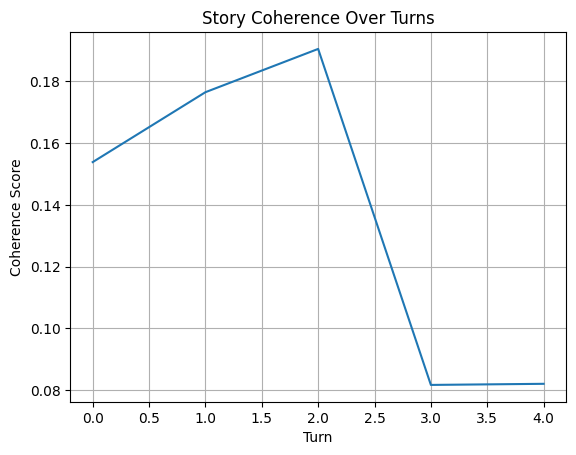

Current Story:
 Plot: ['Current story:  In a quiet village, a mysterious stranger arrived.\nGenerate a plot twist or development: What you gain by doing something in a story is not just what you get from doing it, but also the things you learn as you do. For example, what is a character class when you see him in the story? Do he have a high Int and low Int traits? If so, how is he defined in other ways? What character will he or at what level will they be in his story or show up in their own?\nTo get a sense of the different character classes, you', 'Current story:  In a quiet village, a mysterious stranger arrived. Introduce entered the story.\nGenerate a plot twist or development: How does it feel to be the first person to win at a lottery with an unquantifiable number?\nA game of chess or a game where you must solve the puzzle, but the rules are more complex than that. It really is not easy to make a move from the beginning, as a beginner, you need to memorize the order of the numbe

Provide feedback or a story fragment (or type 'continue'):  good story


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Updated Story After Human Input:
 Plot: ['Current story:  In a quiet village, a mysterious stranger arrived.\nGenerate a plot twist or development: What you gain by doing something in a story is not just what you get from doing it, but also the things you learn as you do. For example, what is a character class when you see him in the story? Do he have a high Int and low Int traits? If so, how is he defined in other ways? What character will he or at what level will they be in his story or show up in their own?\nTo get a sense of the different character classes, you', 'Current story:  In a quiet village, a mysterious stranger arrived. Introduce entered the story.\nGenerate a plot twist or development: How does it feel to be the first person to win at a lottery with an unquantifiable number?\nA game of chess or a game where you must solve the puzzle, but the rules are more complex than that. It really is not easy to make a move from the beginning, as a beginner, you need to memorize the

In [22]:
# Initialize agents and coordinator
plot_agent = PlotAgent()
char_agent = CharacterAgent()
dialogue_agent = DialogueAgent()
coordinator = StoryCoordinator([plot_agent, char_agent, dialogue_agent], max_turns=5)

# Start with an optional human seed
initial_seed = "In a quiet village, a mysterious stranger arrived."
story = coordinator.run_collaboration(human_input=initial_seed)

# Print final story
print("\nFinal Story:\n", story)

# Plot coherence
coordinator.plot_coherence()

# Interactive loop (optional)
story = human_interaction(coordinator)
print("\nUpdated Story After Human Input:\n", story)